In [2]:
## Imports

# Basics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Language Processing

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
from google.colab import drive

drive.mount('/content/drive')

df_poetry = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goodreads-comments/data/reviews_csvs/reviews_poetry.csv')
df_fantasy = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goodreads-comments/data/reviews_csvs/reviews_fantasy_paranormal.csv')

Mounted at /content/drive


In [21]:
reviews_per_book = df_fantasy.groupby('book_id').count().sort_values('review_id', ascending = False)['review_id']
reviews_per_book.head(10)

book_id
16096824    151
23437156    147
17927395    119
29056083    112
18798983     81
22055262     78
22299763     78
17675462     74
17378527     72
13206900     72
Name: review_id, dtype: int64

In [5]:
sum(reviews_per_book > 100)

44

In [6]:
df_fantasy = df_fantasy[df_fantasy['n_votes'] > 30]

In [7]:
df_fantasy.dropna(inplace = True)

(array([5.180e+03, 3.033e+03, 2.768e+03, 2.233e+03, 1.782e+03, 1.216e+03,
        7.830e+02, 5.160e+02, 4.430e+02, 3.230e+02, 2.500e+02, 1.540e+02,
        1.330e+02, 1.080e+02, 7.500e+01, 7.500e+01, 4.700e+01, 3.500e+01,
        3.300e+01, 2.500e+01, 1.700e+01, 1.200e+01, 1.300e+01, 9.000e+00,
        9.000e+00, 1.400e+01, 7.000e+00, 4.000e+00, 5.000e+00, 9.000e+00]),
 array([2.00000000e+00, 6.59466667e+02, 1.31693333e+03, 1.97440000e+03,
        2.63186667e+03, 3.28933333e+03, 3.94680000e+03, 4.60426667e+03,
        5.26173333e+03, 5.91920000e+03, 6.57666667e+03, 7.23413333e+03,
        7.89160000e+03, 8.54906667e+03, 9.20653333e+03, 9.86400000e+03,
        1.05214667e+04, 1.11789333e+04, 1.18364000e+04, 1.24938667e+04,
        1.31513333e+04, 1.38088000e+04, 1.44662667e+04, 1.51237333e+04,
        1.57812000e+04, 1.64386667e+04, 1.70961333e+04, 1.77536000e+04,
        1.84110667e+04, 1.90685333e+04, 1.97260000e+04]),
 <a list of 30 Patch objects>)

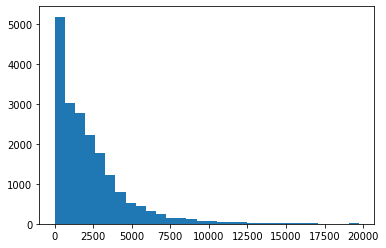

In [8]:
lengths = [len(text) for text in df_fantasy['review_text']]
plt.hist(lengths, bins = 30)

In [9]:
def cleaning(sentence):
    
    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase 
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers
    
    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation
    
    tokenized_sentence = word_tokenize(sentence) ## tokenize 
    stop_words = set(stopwords.words('english')) ## define stopwords
    
    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v") 
        for word in tokenized_sentence_cleaned
    ]
    
    cleaned_sentence = ' '.join(word for word in lemmatized)
    
    return cleaned_sentence

In [10]:
df_fantasy['clean_text'] = df_fantasy['review_text'].apply(cleaning)
df_fantasy.head()

,Unnamed: 0,user_id,book_id,review_id,rating,review_text,n_votes,clean_text
4,4,8842281e1d1347389f2ab93d60773d4d,1022863,36aa8e00ce8032cba6afd6094550feae,5,"When people ask me what my favorite book is, D...",68,people ask favorite book dune always answer wo...
14,14,8e1db93d364acf3893ce998ebb8d57fc,12127810,58ed16fc5189ddb7c3acd685a0946507,4,"October 11, 2013: I finally finished this wond...",47,october finally finish wonderful book happy pr...
33,33,8c6b2fa6608814033375191a10f4eb98,32766747,3316091e9ae73ca7b5d7da195036854e,2,This had so many good ideas but all of them we...,73,many good ideas surface level want know much
34,34,8c6b2fa6608814033375191a10f4eb98,18001518,1ca18cd1ff4acd66bc1d3b6708b761b9,3,3.75 stars! I still really enjoyed this book b...,152,star still really enjoy book felt could book s...
35,35,8c6b2fa6608814033375191a10f4eb98,24885506,16a38327dd48bc3af6d3df744fc16097,4,4.5 stars \n IT IS FINISHED \n well that was a...,227,star finish well rollercoaster emotions course...


In [11]:
clean_text = df_fantasy['clean_text']

In [12]:
vectorizer = TfidfVectorizer(min_df = 50)
vectorized_text = vectorizer.fit_transform(clean_text)
vector_text = pd.DataFrame(vectorized_text.toarray(), 
                                    columns = vectorizer.get_feature_names_out())

vector_text

,abandon,abduct,abercrombie,abilities,ability,able,abound,abrupt,abruptly,absence,...,youth,youtube,youve,yummy,yup,zero,zombie,zombies,zone,zu
0,0.0,0.0,0.0,0.0,0.0,0.032103,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19306,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
19307,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.053175,0.0,0.0,0.0,0.0
19308,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
19309,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [13]:
# Instantiate the LDA 
n_components = 10
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = 100)

# Fit the LDA on the vectorized documents
lda_model.fit(vector_text)

LatentDirichletAllocation(max_iter=100)

In [14]:
topic_word_mixture = pd.DataFrame(lda_model.components_, 
                                 columns = vectorizer.get_feature_names_out())

In [15]:
topic_word_mixture.sum().sort_values(ascending = False)

book       1490.731022
read        854.125466
love        833.908766
like        793.635928
one         698.344567
              ...     
despues       2.881642
tenia         2.865114
tal           2.817661
durante       2.771516
estas         2.440527
Length: 5504, dtype: float64

In [16]:
def print_topics(lda_model, vectorizer, top_words):
    # 1. TOPIC MIXTURE OF WORDS FOR EACH TOPIC
    topic_mixture = pd.DataFrame(lda_model.components_,
                                 columns = vectorizer.get_feature_names_out())
    
    # 2. FINDING THE TOP WORDS FOR EACH TOPIC
    ## Number of topics
    n_components = topic_mixture.shape[0]
    ## Top words for each topic
    for topic in range(n_components):
        print("-"*10)
        print(f"For topic {topic}, here are the the top {top_words} words with weights:")
        topic_df = topic_mixture.iloc[topic]\
                             .sort_values(ascending = False).head(top_words)
        
        print(round(topic_df,3))

In [17]:
print_topics(lda_model, vectorizer, 20)

----------
For topic 0, here are the the top 20 words with weights:
book         222.185
love         153.765
read         124.236
series       118.964
im            88.093
star          81.079
really        78.828
review        72.635
wait          69.491
one           69.212
character     66.025
end           64.289
much          63.583
amaze         63.281
reread        62.145
cant          60.300
like          53.851
time          53.777
write         51.555
first         49.749
Name: 0, dtype: float64
----------
For topic 1, here are the the top 20 words with weights:
book         434.175
love         299.714
like         274.019
read         222.081
get          220.664
im           214.649
go           192.725
know         192.591
one          190.635
really       177.517
want         176.088
series       174.002
character    163.107
dont         157.513
think        155.990
make         154.814
say          147.805
end          139.173
much         137.618
time         136.224


In [18]:
df_fantasy['clean_length'] = df_fantasy['clean_text'].apply(lambda x: len(x))
df_fantasy['clean_length'] > 50

4         True
14        True
33       False
34        True
35        True
         ...  
70058     True
70059     True
70065     True
70083     True
70088     True
Name: clean_length, Length: 19311, dtype: bool

In [19]:
df_fantasy.groupby('book_id')